<a href="https://colab.research.google.com/github/MrCherveN/Machine-Learning--4-0_HomeTasks/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-4'

In [4]:
od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-4" (use force=True to force download)


F1 score: 0.64
Area under ROC score on Training dataset: 0.88


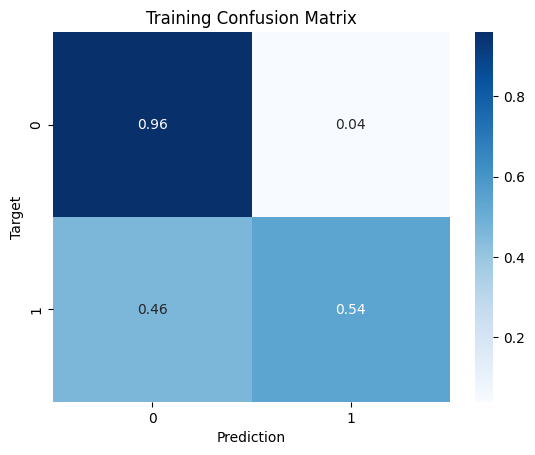

F1 score: 0.64
Area under ROC score on Validation dataset: 0.88


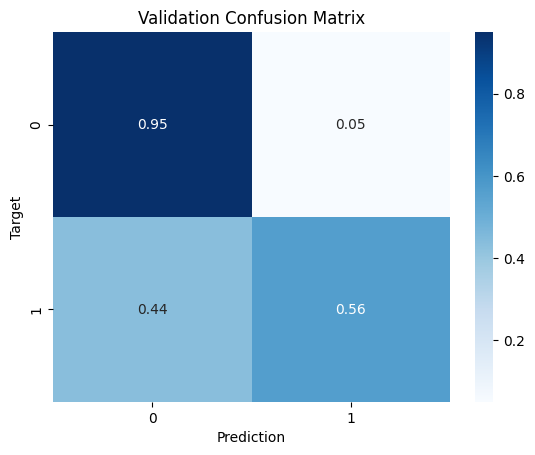

['bank_customer_churn_prediction.joblib']

In [5]:
raw_df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-4/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.20, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
target_col = 'Exited'
input_cols = [col for col in train_df.columns if col not in [target_col, 'id', 'CustomerId', 'Surname']]
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):

    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)

    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}".format(f1))

    fpr, tpr, _ = roc_curve(targets, probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")

    confusion_matrix_= confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')


# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank_customer_churn_prediction.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [6]:
from sklearn.preprocessing import PolynomialFeatures

F1 score: 0.68
Area under ROC score on Training dataset: 0.91


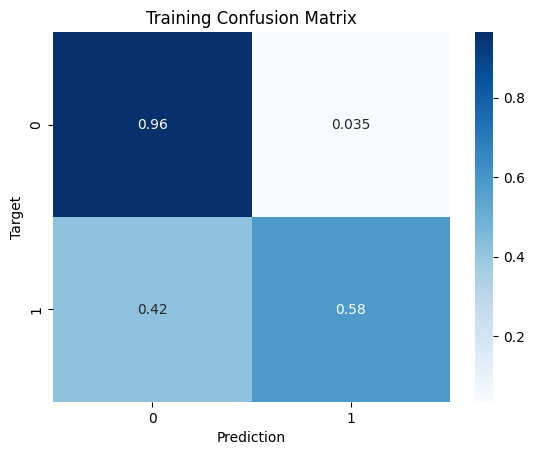

F1 score: 0.68
Area under ROC score on Validation dataset: 0.91


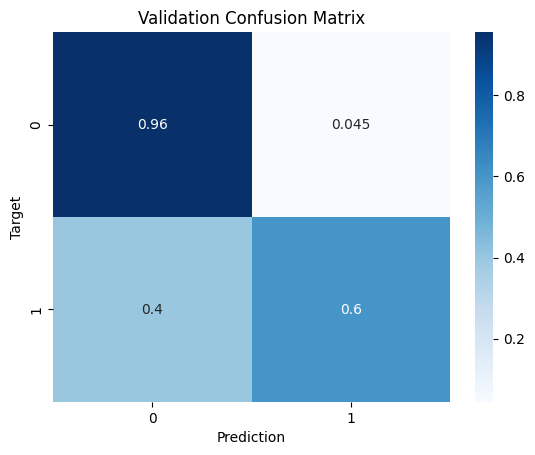

In [7]:
# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer_polinomal_2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
     ( 'polinomal_features', PolynomialFeatures(degree=2)),
    ('scaler', MinMaxScaler())
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor_polinomal_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_polinomal_2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_polinomal_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_polinomal_2),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_polinomal_2.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline_polinomal_2, train_inputs, train_targets, name='Training')
val_preds = predict_and_plot(model_pipeline_polinomal_2, val_inputs, val_targets, name='Validation')

***Висновки:***
- Модель стала відчутно кращою - значення метрик F1 та ROC-AUC покращилися.
- overfit та underfit в моделі не спостерігаються. Модель майже однаково показує високі результати, як на тренувальному, так і на валідаційному наборі.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

F1 score: 0.73
Area under ROC score on Training dataset: 0.93


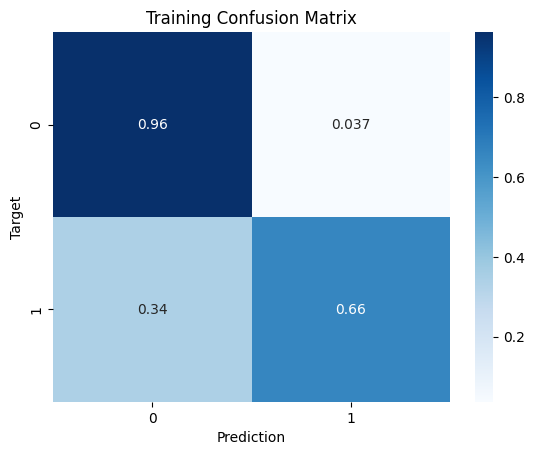

F1 score: 0.72
Area under ROC score on Validation dataset: 0.93


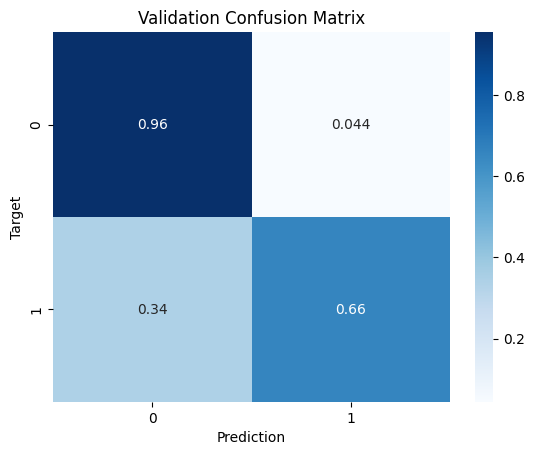

In [8]:
# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer_polinomal_4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
     ( 'polinomal_features', PolynomialFeatures(degree=4)),
    ('scaler', MinMaxScaler())
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor_polinomal_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_polinomal_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_polinomal_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_polinomal_4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_polinomal_4.fit(train_inputs, train_targets)

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline_polinomal_4, train_inputs, train_targets, name='Training')
val_preds = predict_and_plot(model_pipeline_polinomal_4, val_inputs, val_targets, name='Validation')

***Висновки:***
- ROC-AUC та F1 зросли, що говорить про покразення моделі в порівнянні з попереднім завданням.
- overfit та underfit в моделі не спостерігаються.

In [9]:
test_raw_df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-4/test.csv')
exited = model_pipeline_polinomal_4.predict_proba(test_raw_df)[:,1]
test_raw_df['Exited'] = exited
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.084966
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.025358
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.074984
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.377231
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.028864


In [10]:
submission_df = pd.read_csv('/content/bank-customer-churn-prediction-dlu-course-c-4/sample_submission.csv')
submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [11]:
submission_df['Exited'] = test_raw_df['Exited']
submission_df.head()

,id,Exited
0,15000,0.084966
1,15001,0.025358
2,15002,0.074984
3,15003,0.377231
4,15004,0.028864


In [12]:
submission_df.to_csv('submission_log_reg.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df = pd.read_csv('/content/drive/MyDrive/Python/Machine Learning для людей  4.0/Модуль 2. Навчання з учителем/Тема 2.2 Задача класифікації. Логістична регресія. Принцип роботи та методи оцінки якості/data/regression_data.csv')

In [15]:
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [16]:
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error


targets = df['target']
inputs = df.drop('target', axis=1)
X_train, X_test, y_train, y_test  = train_test_split(inputs, targets, test_size=0.20, random_state=42)

polynomial_features = PolynomialFeatures(degree=5)
inputs_train_poly = polynomial_features.fit_transform(X_train)
inputs_test_poly = polynomial_features.fit_transform(X_test)


#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(inputs_train_poly)

scaled_inputs_train_poly = scaler.transform(inputs_train_poly)
scaled_inputs_test_poly = scaler.transform(inputs_test_poly)


model = LinearRegression().fit(scaled_inputs_train_poly, y_train)

predictions_train = model.predict(scaled_inputs_train_poly)
predictions_test = model.predict(scaled_inputs_test_poly)

rmse_train = root_mean_squared_error(y_train, predictions_train)
rmse_test = root_mean_squared_error(y_test, predictions_test)

print(f"Train RMSE: {rmse_train:.3f}")
print(f"Test RMSE: {rmse_test:.3f}\n")

Train RMSE: 0.000
Test RMSE: 12.363



***Висновок:***

Отримані результати показують, що модель має всі ознаки перенавчання та погано генералізує дані. Так на тренувальних даних метрика RMSE  показала, що модель майже ідеальна. Але на тестових значення метрики значно погіршилися.


Важливо:
при виконанні завдання я вирішив змінити порядок операцій з "масштабування та поліноміальні ознаки" на "поліноміальні ознаки та масштабування". Хоча перший варінт мав ще гірші показники.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [17]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [18]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = round(root_mean_squared_error(y_train, y_train_pred), 3)
    val_metrics = round(root_mean_squared_error(y_val, y_val_pred), 3)

    return dict(train=train_metrics, val=val_metrics)

In [19]:
polynomial_features = PolynomialFeatures(degree=20)
inputs_train_poly = polynomial_features.fit_transform(X_train)
inputs_test_poly = polynomial_features.fit_transform(X_test)


#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(inputs_train_poly)

scaled_inputs_train_poly = scaler.transform(inputs_train_poly)
scaled_inputs_test_poly = scaler.transform(inputs_test_poly)

In [20]:
models = [
    Ridge(),
    Lasso(),
    ElasticNet()
]

for model in models:
    model.fit(scaled_inputs_train_poly, y_train)
    eval_results  = evaluate_model(model, scaled_inputs_train_poly, y_train, scaled_inputs_test_poly, y_test)
    print(f'{str(model)} RMSE: {eval_results}')
    print(f'Кількість ненульових коефіцієнтів моделі {str(model)} : {np.sum(model.coef_ != 0)}\n')

Ridge() RMSE: {'train': 8.598, 'val': 76.563}
Кількість ненульових коефіцієнтів моделі Ridge() : 53129

Lasso() RMSE: {'train': 5.098, 'val': 5.672}
Кількість ненульових коефіцієнтів моделі Lasso() : 1

ElasticNet() RMSE: {'train': 34.18, 'val': 116.03}
Кількість ненульових коефіцієнтів моделі ElasticNet() : 998



***Висновок:***

Найкраще генералызує модель Lasso, оскільки модель відкинула зайві ознаки, які створювали шум.  